In [9]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, List

pd.set_option('display.max_rows', 500)

os.chdir("C:/Users/jerem/OneDrive/Documents/rocketleague_ml")
file_name = "debug"
focused_player_name = "RL_LionHeart"
round = 4

X_MAX = 4096
Y_MAX = 5120
BEVEL = 1056  # diagonal cut

FIELD_X = [-4096, 4096, 4096, -4096, -4096]
FIELD_Y = [-5120, -5120, 5120, 5120, -5120]

# Define polygon with beveled corners
FIELD_OUTLINE = [
    (-X_MAX + BEVEL, Y_MAX),   # top left bevel start
    (X_MAX - BEVEL, Y_MAX),    # top right bevel start
    (X_MAX, Y_MAX - BEVEL),    # top right bevel end
    (X_MAX, -Y_MAX + BEVEL),   # bottom right bevel start
    (X_MAX - BEVEL, -Y_MAX),   # bottom right bevel end
    (-X_MAX + BEVEL, -Y_MAX),  # bottom left bevel start
    (-X_MAX, -Y_MAX + BEVEL),  # bottom left bevel end
    (-X_MAX, Y_MAX - BEVEL),   # top left bevel end
    (-X_MAX + BEVEL, Y_MAX)    # close the polygon
]
processed_file = f"data/processed/{file_name}.csv"

game = pd.read_csv(processed_file, low_memory=False) # type: ignore

cols = game.columns
loc_cols = [c for c in cols if c.endswith('_positioning_x')]
player_cols = [c for c in loc_cols if not c.startswith('ball_')]
player_names = [c.replace('_positioning_x', '') for c in player_cols]
player_team = game[f"{focused_player_name}_team"][game[f"{focused_player_name}_team"].notna() & (game[f"{focused_player_name}_team"] != '')].iloc[0]
teammates: List[str] = []
opponents: List[str] = []
for player_name in player_names:
    if player_name == focused_player_name:
        continue
    team = game[f"{player_name}_team"][game[f"{player_name}_team"].notna() & (game[f"{player_name}_team"] != '')].iloc[0]
    if team == player_team:
        teammates.append(player_name)
    else:
        opponents.append(player_name)

flip_x = True if player_team == "Blue" else False
flip_y = True if player_team == "Orange" else False

game = game[game["active"]]
game.head()

,id,time,delta,round,active,match_time_label,Epricity_positioning_sleeping,Epricity_positioning_x,Epricity_positioning_y,Epricity_positioning_z,...,ball_positioning_linear_velocity_z,ball_positioning_angular_velocity_x,ball_positioning_angular_velocity_y,ball_positioning_angular_velocity_z,RL_LionHeart_team,TOKEDRL_team,samheungmin actl_team,Epricity_team,Captain_zay_team,ItsSoulstice_team
114,2EF689F5462A8F2B981329B15D08402A,8.075035,0.034966,1,True,5:02,0.0,-2048.27,-2560.16,17.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,2EF689F5462A8F2B981329B15D08402A,8.110002,0.034966,1,True,5:02,0.0,-2048.27,-2560.16,17.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,2EF689F5462A8F2B981329B15D08402A,8.144971,0.034969,1,True,5:02,0.0,-2048.27,-2560.16,17.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,2EF689F5462A8F2B981329B15D08402A,8.179937,0.034966,1,True,5:02,0.0,-2055.77,-2565.38,17.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118,2EF689F5462A8F2B981329B15D08402A,8.214904,0.034966,1,True,5:02,0.0,-2055.77,-2565.38,17.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
if flip_y:
    y_cols = [c for c in game.columns if c.endswith('_y') and "rotation" not in c]
    game[y_cols] = -game[y_cols]

# Positioning

### Calculate Player Distances to Ball

In [ ]:
for player_name in player_names:
    prefix = player_name + "_"
    if player_name == focused_player_name:
        game["positioning_x"] = game[f"{prefix}positioning_x"]
        game["positioning_y"] = game[f"{prefix}positioning_y"]
        game["positioning_z"] = game[f"{prefix}positioning_z"]
        prefix = ""

    game[f"{prefix}distance_to_ball"] = np.sqrt(
        (game[f"{prefix}positioning_x"] - game["ball_positioning_x"]) ** 2 +
        (game[f"{prefix}positioning_y"] - game["ball_positioning_y"]) ** 2 +
        (game[f"{prefix}positioning_z"] - game["ball_positioning_z"]) ** 2
    )

In [ ]:
for player_name in player_names:
    if player_name == focused_player_name:
        continue

    game[f"distance_to_{player_name}"] = np.sqrt(
        (game["positioning_x"] - game[f"{player_name}_positioning_x"]) ** 2 +
        (game["positioning_y"] - game[f"{player_name}_positioning_y"]) ** 2 +
        (game["positioning_z"] - game[f"{player_name}_positioning_z"]) ** 2
    )

## Field Positioning

In [ ]:
max_y = abs(FIELD_Y[0])
third_of_y = max_y / 3
game["offensive_half"] = game["positioning_y"] > 0
game["defensive_half"] = game["positioning_y"] <= 0
game["offensive_third"] = game["positioning_y"] >= third_of_y
game["neutral_third"] = (game["positioning_y"] < third_of_y) & (game["positioning_y"] > -third_of_y)
game["defensive_third"] = game["positioning_y"] <= -third_of_y

game["left_half"] = game["positioning_x"] > 0
game["right_half"] = game["positioning_x"] <= 0
game["left_third"] = game["positioning_x"] >= third_of_y
game["middle_third"] = (game["positioning_x"] < third_of_y) & (game["positioning_x"] > -third_of_y)
game["right_third"] = game["positioning_x"] <= -third_of_y

distance_cols = [c for c in game.columns if c.endswith("_distance_to_ball") or c == "distance_to_ball"]
game["closest_to_ball"] = game["distance_to_ball"] == game[distance_cols].min(axis=1)
game["farthest_from_ball"] = game["distance_to_ball"] == game[distance_cols].max(axis=1)
game["in_front_of_ball"] = game["positioning_y"] > game["ball_positioning_y"] 
game["behind_ball"] = game["positioning_y"] < game["ball_positioning_y"]

# tolerances so we don't misclassify tiny bounces
Z_GROUND = 30
Z_CEILING = 2000
X_WALL = 4096
Y_WALL = 5120
X_GOAL = 892
GOAL_DEPTH = 880
TOL = 50  # tolerance in uu

game["grounded"] = game["positioning_z"].between(0, Z_GROUND) # type: ignore
game["on_ceiling"] = game["positioning_z"] >= Z_CEILING

game["on_left_wall"] = game["positioning_x"] <= -X_WALL + TOL
game["on_right_wall"] = game["positioning_x"] >= X_WALL - TOL

# Goal regions
game["in_own_goal"] = (
    (game["positioning_x"].between(-X_GOAL, X_GOAL)) & # type: ignore
    (game["positioning_y"] <= -(Y_WALL - TOL)) &
    (game["positioning_y"] >= -(Y_WALL + GOAL_DEPTH + TOL))
)
game["in_opponents_goal"] = (
    (game["positioning_x"].between(-X_GOAL, X_GOAL)) & # type: ignore
    (game["positioning_y"] >= (Y_WALL - TOL)) &
    (game["positioning_y"] <= (Y_WALL + GOAL_DEPTH + TOL))
)

# Wall checks, excluding goal occupancy
game["on_back_wall"] = (
    (game["positioning_y"] <= -(Y_WALL - TOL)) &
    (~game["in_own_goal"])
)
game["on_front_wall"] = (
    (game["positioning_y"] >= (Y_WALL - TOL)) &
    (~game["in_opponents_goal"])
)

# airborne = none of the above
game["airborne"] = ~(
    game["grounded"] |
    game["on_ceiling"] |
    game["on_left_wall"] |
    game["on_right_wall"] |
    game["on_back_wall"] |
    game["on_front_wall"]
)

game.head().T

# Calculate Summary Metrics

In [ ]:
game.describe().T
summay = {}

In [ ]:
def get_position_stats_for(cols: Union[str, List[str]]):
    total_time = game["delta"].sum()

    # build mask
    if isinstance(cols, str):
        mask = game[cols]
    else:
        mask = game[cols].all(axis=1)   # AND across provided columns

    # percentage time
    time_in_position = game.loc[mask, "delta"].sum()
    perc_in_position = time_in_position / total_time if total_time > 0 else 0

    # find runs/stints
    run_ids = mask.ne(mask.shift()).cumsum()
    stint_groups = game[mask].groupby(run_ids) # type: ignore

    # duration per stint
    stint_durations = stint_groups["delta"].sum()

    # average stint duration
    avg_stint = stint_durations.mean() if not stint_durations.empty else 0

    return perc_in_position, avg_stint

In [ ]:
perc_offensive, avg_offensive_stint = get_position_stats_for("offensive_half")
perc_defensive, avg_defensive_stint = get_position_stats_for("defensive_half")

perc_offensive_third, avg_offensive_third_stint = get_position_stats_for(
    "offensive_third"
)
perc_neutral_third, avg_neutral_third_stint = get_position_stats_for("neutral_third")
perc_defensive_third, avg_defensive_third_stint = get_position_stats_for(
    "defensive_third"
)

summary = pd.DataFrame(
    {
        "Labels": [
            "Percentage Time in Offensive Half",
            "Average Stint of Time in Offensive Half",
            "Percentage Time in Defensive Half",
            "Average Stint of Time in Defensive Half",
            "Percentage Time in Offensive Third",
            "Average Stint in Offensive Third",
            "Percentage Time in Neutral Third",
            "Average Stint in Neutral Third",
            "Percentage Time in Defensive Third",
            "Average Stint in Defensive Third",
        ],
        "Metrics": [
            f"{perc_offensive:.2%}",
            f"{avg_offensive_stint:.2f}",
            f"{perc_defensive:.2%}",
            f"{avg_defensive_stint:.2f}",
            f"{perc_offensive_third:.2%}",
            f"{avg_offensive_third_stint:.2f}",
            f"{perc_neutral_third:.2%}",
            f"{avg_neutral_third_stint:.2f}",
            f"{perc_defensive_third:.2%}",
            f"{avg_defensive_third_stint:.2f}",
        ],
    }
)
summary

In [ ]:
perc_left, avg_left_stint = get_position_stats_for("left_half")
perc_right, avg_right_stint = get_position_stats_for("right_half")

perc_left_third, avg_left_third_stint = get_position_stats_for("left_third")
perc_middle_third, avg_middle_third_stint = get_position_stats_for("middle_third")
perc_right_third, avg_right_third_stint = get_position_stats_for("right_third")

In [ ]:
perc_offensive_left, avg_offensive_left_stint = get_position_stats_for(["offensive_half", "left_half"])
perc_offensive_right, avg_offensive_right_stint = get_position_stats_for(["offensive_half", "right_half"])
perc_defensive_left, avg_defensive_left_stint = get_position_stats_for(["defensive_half", "left_half"])
perc_defensive_right, avg_defensive_right_stint = get_position_stats_for(["defensive_half", "right_half"])

In [ ]:
perc_offensive_left_third, avg_offensive_left_third_stint = get_position_stats_for(["offensive_third", "left_third"])
perc_offensive_middle_third, avg_offensive_middle_third_stint = get_position_stats_for(["offensive_third", "middle_third"])
perc_offensive_right_third, avg_offensive_right_third_stint = get_position_stats_for(["offensive_third", "right_third"])

perc_neutral_left_third, avg_neutral_left_third_stint = get_position_stats_for(["neutral_third", "left_third"])
perc_neutral_middle_third, avg_neutral_middle_third_stint = get_position_stats_for(["neutral_third", "middle_third"])
perc_neutral_right_third, avg_neutral_right_third_stint = get_position_stats_for(["neutral_third", "right_third"])

perc_defensive_left_third, avg_defensive_left_third_stint = get_position_stats_for(["defensive_third", "left_third"])
perc_defensive_middle_third, avg_defensive_middle_third_stint = get_position_stats_for(["defensive_third", "middle_third"])
perc_defensive_right_third, avg_defensive_right_third_stint = get_position_stats_for(["defensive_third", "right_third"])

In [ ]:
perc_closest, avg_closest_stint = get_position_stats_for("closest_to_ball")
perc_farthest, avg_farthest_stint = get_position_stats_for("farthest_from_ball")
perc_in_front, avg_in_front_stint = get_position_stats_for("in_front_of_ball")
perc_behind, avg_behind_stint = get_position_stats_for("behind_ball")

In [ ]:
perc_grounded, avg_grounded_stint = get_position_stats_for("grounded")
perc_airborne, avg_airborne_stint = get_position_stats_for("airborne")
perc_on_ceiling, avg_on_ceiling_stint = get_position_stats_for("on_ceiling")
perc_on_left_wall, avg_on_left_wall_stint = get_position_stats_for("on_left_wall")
perc_on_right_wall, avg_on_right_wall_stint = get_position_stats_for("on_right_wall")
perc_on_back_wall, avg_on_back_wall_stint = get_position_stats_for("on_back_wall")
perc_on_front_wall, avg_on_front_wall_stint = get_position_stats_for("on_front_wall")
perc_in_own_goal, avg_in_own_goal_stint = get_position_stats_for("in_own_goal")
perc_in_opponents_goal, avg_in_opponents_goal_stint = get_position_stats_for("in_opponents_goal")

In [ ]:
avg_distance_to_ball = game["distance_to_ball"].mean()
teammate_distances = [f"distance_to_{teammate}" for teammate in teammates]
avg_distance_to_teammates = game[teammate_distances].mean(axis=1).mean()
opponent_distances = [f"distance_to_{opponent}" for opponent in opponents]
avg_distance_to_opponents = game[opponent_distances].mean(axis=1).mean()

In [ ]:
time_filter = ((game["time"]) > 1)
xs = game["time"][time_filter]
xs

In [ ]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(9, 6))

# plot player positions
time_filter = ((game["time"] >= 0) & (game["time"] <= 30))
xs = game["positioning_x"][time_filter]
ys = game["positioning_y"][time_filter]
ball_xs = game["ball_positioning_x"][time_filter]
ball_ys = game["ball_positioning_y"][time_filter]
ax.plot(xs, ys, color=player_team.lower(), alpha=0.7, linewidth=2)
# ax.plot(ball_xs, ball_ys, color="black", alpha=0.5)

ax.legend(
    loc='lower left',       # or 'lower left', etc.
    frameon=False,           # removes box background
    labelcolor='white',      # if background is dark
)

field_x, field_y = zip(*FIELD_OUTLINE)
ax.plot(field_x, field_y, color="grey", alpha=0.7)

# Goal dimensions (approx in UU)
GOAL_WIDTH = 1786  # post-to-post (x)
GOAL_DEPTH = 880  # into the field (y)

# Blue goal (at y = -5120, facing upfield)
team_goal = patches.Rectangle(
    (-GOAL_WIDTH / 2, -5120 - GOAL_DEPTH),  # bottom-left corner
    GOAL_WIDTH,
    GOAL_DEPTH,
    edgecolor=player_team.lower(),
    facecolor="none",
)
ax.add_patch(team_goal)

# Orange goal (at y = +5120, facing downfield)
opp_goal = patches.Rectangle(
    (-GOAL_WIDTH / 2, 5120),  # bottom-left corner
    GOAL_WIDTH,
    GOAL_DEPTH,
    edgecolor="orange" if player_team == "Blue" else "blue",
    facecolor="none",
)
ax.add_patch(opp_goal)

BOOST_PAD_MAP = {
    0: (0.0, -4240.0, 70.0, 12),
    1: (-1792.0, -4184.0, 70.0, 12),
    2: (1792.0, -4184.0, 70.0, 12),
    3: (-3072.0, -4096.0, 73.0, 100),  # big
    4: (3072.0, -4096.0, 73.0, 100),  # big
    5: (-940.0, -3308.0, 70.0, 12),
    6: (940.0, -3308.0, 70.0, 12),
    7: (0.0, -2816.0, 70.0, 12),
    8: (-3584.0, -2484.0, 70.0, 12),
    9: (3584.0, -2484.0, 70.0, 12),
    10: (-1788.0, -2300.0, 70.0, 12),
    11: (1788.0, -2300.0, 70.0, 12),
    12: (-2048.0, -1036.0, 70.0, 12),
    13: (0.0, -1024.0, 70.0, 12),
    14: (2048.0, -1036.0, 70.0, 12),
    15: (-3584.0, 0.0, 73.0, 100),  # big
    16: (-1024.0, 0.0, 70.0, 12),
    17: (1024.0, 0.0, 70.0, 12),
    18: (3584.0, 0.0, 73.0, 100),  # big
    19: (-2048.0, 1036.0, 70.0, 12),
    20: (0.0, 1024.0, 70.0, 12),
    21: (2048.0, 1036.0, 70.0, 12),
    22: (-1788.0, 2300.0, 70.0, 12),
    23: (1788.0, 2300.0, 70.0, 12),
    24: (-3584.0, 2484.0, 70.0, 12),
    25: (3584.0, 2484.0, 70.0, 12),
    26: (0.0, 2816.0, 70.0, 12),
    27: (-940.0, 3308.0, 70.0, 12),
    28: (940.0, 3308.0, 70.0, 12),
    29: (-3072.0, 4096.0, 73.0, 100),  # big
    30: (3072.0, 4096.0, 73.0, 100),  # big
}

# --- Add Boost Pads ---
small_pads = [(x, y) for (x, y, z, size) in BOOST_PAD_MAP.values() if size == 12]
big_pads   = [(x, y) for (x, y, z, size) in BOOST_PAD_MAP.values() if size == 100]

ax.scatter(
    [x for x, y in small_pads],
    [y for x, y in small_pads],
    color='yellow',
    s=2,
    label='Small Boost'
)
ax.scatter(
    [x for x, y in big_pads],
    [y for x, y in big_pads],
    color='yellow',
    s=2,
    label='Big Boost'
)

ax.set_facecolor("#2e7d32")

ax.set_title(f"{focused_player_name} XY Position")

ax.set_aspect("equal", "box")
ax.set_xlim(-X_MAX, X_MAX)
ax.set_ylim(-6000, 6000)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
# ax.set_frame_on(False)  # removes the outer box

# Add legend (place it where it won’t cover your field)

plt.show()

In [ ]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection="3d")
xs = game["positioning_x"][time_filter]
ys = game["positioning_y"][time_filter]
ball_xs = game["ball_positioning_x"][time_filter]
ball_ys = game["ball_positioning_y"][time_filter]
ax.plot(xs, ys, color=player_team.lower(), alpha=0.7, linewidth=2)

# Draw field outline (wireframe)
field_x_3D = [-4096, 4096]
field_y_3D = [-5120, 5120]
field_z_3D = [0, 2044]

# Helper to draw goal as wireframe box
def draw_goal(ax, y_center, color="red", alpha=0.2):
    # Corners of the goal
    x0, x1 = -X_GOAL, X_GOAL
    y0, y1 = y_center, y_center + (GOAL_DEPTH if y_center > 0 else -GOAL_DEPTH)
    z0, z1 = [0, 642]

    # 8 vertices of goal box
    verts = [
        [x0, y0, z0],
        [x1, y0, z0],
        [x1, y1, z0],
        [x0, y1, z0],
        [x0, y0, z1],
        [x1, y0, z1],
        [x1, y1, z1],
        [x0, y1, z1],
    ]

    # 6 faces
    faces = [
        [verts[i] for i in [0, 1, 2, 3]],  # bottom
        [verts[i] for i in [4, 5, 6, 7]],  # top
        [verts[i] for i in [0, 1, 5, 4]],  # front
        [verts[i] for i in [2, 3, 7, 6]],  # back
        [verts[i] for i in [1, 2, 6, 5]],  # right
        [verts[i] for i in [0, 3, 7, 4]],  # left
    ]

    ax.add_collection3d(Poly3DCollection(faces, facecolors=color, linewidths=1, edgecolors=color, alpha=alpha))

# Draw goals
draw_goal(ax, Y_WALL, color="orange", alpha=0.05)    # Opponent's goal
draw_goal(ax, -Y_WALL, color="blue", alpha=0.05)

# 12 edges of the field box
for x in field_x_3D:
    for y in field_y_3D:
        ax.plot([x, x], [y, y], field_z_3D, color="black")  # verticals
for z in field_z_3D:
    ax.plot(
        field_x_3D, [field_y_3D[0], field_y_3D[0]], [z, z], color="black"
    )  # front/back X edges
    ax.plot(field_x_3D, [field_y_3D[1], field_y_3D[1]], [z, z], color="black")
    ax.plot(
        [field_x_3D[0], field_x_3D[0]], field_y_3D, [z, z], color="black"
    )  # left/right Y edges
    ax.plot([field_x_3D[1], field_x_3D[1]], field_y_3D, [z, z], color="black")

ax.set_title("Ball Trajectory in Rocket League Field")
ax.set_xlabel("X (width)")
ax.set_ylabel("Y (length)")
ax.set_zlabel("Z (height)")

# Set field limits
ax.set_xlim(field_x_3D)
ax.set_ylim(-6000, 6000)
ax.set_zlim(field_z_3D)
plt.show()


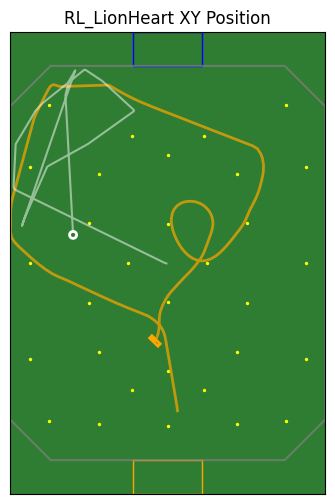

In [ ]:
import math
import numpy as np
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(9, 6))
frame_idx = 500  # or pick a timestamp filter, e.g. game.loc[game['time'] == 10.5].iloc[0]
xs = game[f"{focused_player_name}_positioning_x"][:frame_idx]
ys = game[f"{focused_player_name}_positioning_y"][:frame_idx]
ball_xs = game["ball_positioning_x"][:frame_idx]
ball_ys = game["ball_positioning_y"][:frame_idx]
ax.plot(xs, ys, color=player_team.lower(), alpha=0.7, linewidth=2)
ax.plot(ball_xs, ball_ys, color="white", alpha=0.5)

field_x, field_y = zip(*FIELD_OUTLINE)
ax.plot(field_x, field_y, color="grey", alpha=0.7)

# Goal dimensions (approx in UU)
GOAL_WIDTH = 1786  # post-to-post (x)
GOAL_DEPTH = 880  # into the field (y)

# Blue goal (at y = -5120, facing upfield)
team_goal = patches.Rectangle(
    (-GOAL_WIDTH / 2, -5120 - GOAL_DEPTH),  # bottom-left corner
    GOAL_WIDTH,
    GOAL_DEPTH,
    edgecolor=player_team.lower(),
    facecolor="none",
)
ax.add_patch(team_goal)

# Orange goal (at y = +5120, facing downfield)
opp_goal = patches.Rectangle(
    (-GOAL_WIDTH / 2, 5120),  # bottom-left corner
    GOAL_WIDTH,
    GOAL_DEPTH,
    edgecolor="orange" if player_team == "Blue" else "blue",
    facecolor="none",
)
ax.add_patch(opp_goal)

BOOST_PAD_MAP = {
    0: (0.0, -4240.0, 70.0, 12),
    1: (-1792.0, -4184.0, 70.0, 12),
    2: (1792.0, -4184.0, 70.0, 12),
    3: (-3072.0, -4096.0, 73.0, 100),  # big
    4: (3072.0, -4096.0, 73.0, 100),  # big
    5: (-940.0, -3308.0, 70.0, 12),
    6: (940.0, -3308.0, 70.0, 12),
    7: (0.0, -2816.0, 70.0, 12),
    8: (-3584.0, -2484.0, 70.0, 12),
    9: (3584.0, -2484.0, 70.0, 12),
    10: (-1788.0, -2300.0, 70.0, 12),
    11: (1788.0, -2300.0, 70.0, 12),
    12: (-2048.0, -1036.0, 70.0, 12),
    13: (0.0, -1024.0, 70.0, 12),
    14: (2048.0, -1036.0, 70.0, 12),
    15: (-3584.0, 0.0, 73.0, 100),  # big
    16: (-1024.0, 0.0, 70.0, 12),
    17: (1024.0, 0.0, 70.0, 12),
    18: (3584.0, 0.0, 73.0, 100),  # big
    19: (-2048.0, 1036.0, 70.0, 12),
    20: (0.0, 1024.0, 70.0, 12),
    21: (2048.0, 1036.0, 70.0, 12),
    22: (-1788.0, 2300.0, 70.0, 12),
    23: (1788.0, 2300.0, 70.0, 12),
    24: (-3584.0, 2484.0, 70.0, 12),
    25: (3584.0, 2484.0, 70.0, 12),
    26: (0.0, 2816.0, 70.0, 12),
    27: (-940.0, 3308.0, 70.0, 12),
    28: (940.0, 3308.0, 70.0, 12),
    29: (-3072.0, 4096.0, 73.0, 100),  # big
    30: (3072.0, 4096.0, 73.0, 100),  # big
}

# --- Add Boost Pads ---
small_pads = [(x, y) for (x, y, z, size) in BOOST_PAD_MAP.values() if size == 12]
big_pads   = [(x, y) for (x, y, z, size) in BOOST_PAD_MAP.values() if size == 100]

ax.scatter(
    [x for x, y in small_pads],
    [y for x, y in small_pads],
    color='yellow',
    s=2,
    label='Small Boost'
)
ax.scatter(
    [x for x, y in big_pads],
    [y for x, y in big_pads],
    color='yellow',
    s=2,
    label='Big Boost'
)

ax.set_facecolor("#2e7d32")

ax.set_title(f"{focused_player_name} XY Position")

ax.set_aspect("equal", "box")
ax.set_xlim(-X_MAX, X_MAX)
ax.set_ylim(-6000, 6000)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
# ax.set_frame_on(False)  # removes the outer box

# Add legend (place it where it won’t cover your field)

def quaternion_to_yaw(x, y, z, w):
    """Convert quaternion to yaw angle (radians) for 2D top-down rotation."""
    siny_cosp = 2 * (w * z + x * y)
    cosy_cosp = 1 - 2 * (y * y + z * z)
    return math.atan2(siny_cosp, cosy_cosp)

def draw_actor_box(ax, position, rotation, color="white", car_length=118, car_width=84):
    """Draw a car box centered at position (x, y) with given quaternion rotation."""
    x, y, _ = position
    qx, qy, qz, qw = rotation
    yaw = quaternion_to_yaw(qx, qy, qz, qw)

    # Car half-dimensions
    hl, hw = car_length / 2, car_width / 2

    # Car corners before rotation (local space)
    corners = np.array([
        [ hl,  hw],
        [ hl, -hw],
        [-hl, -hw],
        [-hl,  hw]
    ])

    # 2D rotation matrix
    R = np.array([
        [math.cos(yaw), -math.sin(yaw)],
        [math.sin(yaw),  math.cos(yaw)]
    ])

    # Rotate + translate
    world_corners = corners @ R.T + np.array([x, y])

    # Create polygon patch
    polygon = plt.Polygon(world_corners, closed=True, edgecolor=color, facecolor="none", lw=2)
    ax.add_patch(polygon)

    # Optional: draw a small line to show facing direction
    front_center = np.array([x, y]) + np.dot(R, np.array([hl, 0]))
    ax.plot([x, front_center[0]], [y, front_center[1]], color=color, lw=1.5)

def draw_ball(ax, position, color="white", radius=91.25):
    """
    Draw the Rocket League ball as a polygonal circle (radius in UU).
    The real ball radius is ~91.25 Unreal units.
    """
    x, y, _ = position
    circle = plt.Circle((x, y), radius, edgecolor=color, facecolor="none", lw=2)
    ax.add_patch(circle)

# Example: pick a single frame
frame = game.iloc[frame_idx]

# Extract position + quaternion from the frame
position = (
    frame[f"{focused_player_name}_positioning_x"],
    frame[f"{focused_player_name}_positioning_y"],
    frame[f"{focused_player_name}_positioning_z"]
)
rotation = (
    frame[f"{focused_player_name}_positioning_rotation_x"],
    frame[f"{focused_player_name}_positioning_rotation_y"],
    frame[f"{focused_player_name}_positioning_rotation_z"],
    frame[f"{focused_player_name}_positioning_rotation_w"]
)
ball_position = (
    frame["ball_positioning_x"],
    frame["ball_positioning_y"],
    frame["ball_positioning_z"]
)

# Draw the car on the field
draw_actor_box(ax, position, rotation, color=player_team.lower())
draw_ball(ax, ball_position)
plt.show()